<a href="https://colab.research.google.com/github/SESCDS/sescds/blob/master/Lesson3_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Основы Pytorch </h1> 

<p>В этот раз мы снова сделаем линейную регрессию, но уже с использованием стандартных методов Pytorch - это может подготовиться к созданию более сложных моделей</p>

<h2>Подготовка</h2>
Это вспомогательные функции для визуализации, нет нужды разбираться в них, просто пройдите по ячейкам

In [0]:
# Нужные библиотеки

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

Класс <code>plot_error_surfaces</code> поможет отрисовать пространство данных (x, y) и пространство параметров (w0, w1), чтобы лучше видеть, что происходит во время тренировки

In [0]:
# class for ploting  

class plot_error_surfaces(object):
    
    # Constructor
    def __init__(self, w1_range, w0_range, X, Y, n_samples = 30, go = False):
        W = np.linspace(-w1_range, w1_range, n_samples)
        B = np.linspace(-w0_range, w0_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y + w2 * self.x + b2) ** 2)
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure(figsize = (15, 10))
            plt.figure(figsize = (15, 10))
            plt.axes(projection = '3d').plot_surface(self.w, self.b, self.Z, rstride = 1, cstride = 1, cmap = 'viridis', edgecolor = 'none')
            plt.title('Loss Surface')
            plt.xlabel('w0')
            plt.ylabel('w1')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w0')
            plt.ylabel('w1')
            plt.contour(self.w, self.b, self.Z, levels=20)
            plt.show()
            
    # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.LOSS.append(loss)
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
    
    # Plot diagram
    def final_plot(self):
        plt.figure(figsize = (15, 10))
        ax = plt.axes(projection = '3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c = 'r', marker = 'x', s = 200, alpha = 1)
        plt.figure(figsize = (15, 10))
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram    
    def plot_ps(self):
        plt.figure(figsize = (10, 5))
        plt.subplot(121)
        plt.ylim()
        plt.plot(self.x, self.y, 'ro', label = "training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label = "estimated line")
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-10, 15))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.subplot(122)
        plt.contour(self.b, self.w, self.Z, levels=20)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.title('Loss Surface Contour Iteration' + str(self.n) )
        plt.xlabel('w1')
        plt.ylabel('w0')
        plt.show()

<h2>Сгенерируем данные</h2>

Импорт библиотек

In [0]:
# Импорт библиотек и установка random_seed - параметра, который обеспечит воспроизводимость случайных чисел

import torch
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(1)

Создадим датасет в стиле Pytorch - это класс, который возвращает данные.

In [0]:
# Создаем класс Data - он наследует класс Dataset.

class Data(Dataset):
    
    # Конструктор
    
    #В любом классе сначала идет инициализация - это действия, которые произойдут при его создании. 
    #В нашем случае мы при создании сгенерируем массивы х и y.
    def __init__(self):
        self.x = torch.arange(-1, 1, 0.02).view(-1, 1)
        self.f = 1 * self.x - 1 #это "правильная" функция от x
        self.y = self.f + 0.2 * torch.randn(self.x.size()) # это "реальные данные" с шумом
        self.len = self.x.shape[0] # это размер данных
        
    # Первая из двух обязательных функций класса Dataset - она возвращает одну точку из данных,
    #т. е. в нашем случае одну пару (x,y)
    def __getitem__(self,index):    
        return self.x[index],self.y[index]
    
    # Вторая из обязательных функций класса Dataset - она возвращает количество точек.
    def __len__(self):
        return self.len

Теперь создадим объект класса Data: 

In [0]:
# Создаем объект класса Data

dataset = Data()

Построим график с данными:

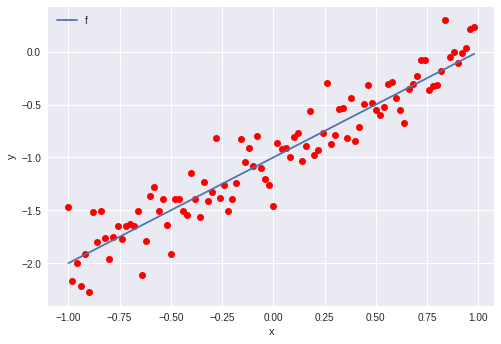

In [0]:
# График с данными
# Обратите внимание, что бы обращаемся к атрибутам класса dataset: dataset.x и т.п.
# Также, поскольку изначально x, y  - это тензоры, с которыми matplotlib напрямую не работает, мы перводим их в numpy
plt.plot(dataset.x.numpy(), dataset.y.numpy(), 'ro')
plt.plot(dataset.x.numpy(), dataset.f.numpy(), label = 'f')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

<!--Empty Space for separating topics-->

<h2>Создадим модель и зададим функцию ошибок</h2>

Создадим класс линейной регрессии

In [0]:
# Мы уже подошли к самому главному - созданию своей архитектуры. Начнем с однослойной, т.е. просто линейной регрессии.

from torch import nn, optim

# Каждая архтиектура должна наследовать nn.Module
class linear_regression(nn.Module):
    
    # Конструктор - в него передаются параметры слоев
    def __init__(self, input_size, output_size):
        # Следующая функция отвечает за инициализацию родительского класса nn.Module
        # Её разбор - более глубокое погружение в ООП, чем нам нужно, пока просто примите её как особенность Pytorch
        super(linear_regression, self).__init__() #аргументы - название нашего класса и self
        
        # Создаем лиейную функцию
        self.linear = nn.Linear(input_size, output_size)
        
        
    # Предсказания - обязательный метод, здесь идет проход черз слои нейросети
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

Создадим объект класса linear_regression

In [0]:
# Архитектура

model = linear_regression(1,1)

Теперь создадим функцию, которая будет считать ошибку. В Pytorch уже есть среднеквадратичное отклонение:

In [0]:
# Функция ошибок

criterion = nn.MSELoss()

Создадим оптимизатор - объект, который будет осуществлять градиентный спуск

In [0]:
# Оптимизатор
optimizer = optim.SGD(model.parameters(), lr = 0.03)

Оптимизатор всегда тесно связан с моделью, в качестве аргументов принимает параметры модели и learning_rate.

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter2/2.4model_optmiz.png" width="100" alt="Model Optimizer" />

Создадим объект <code>Dataloader</code>  - он отвечает за то, чтобы делать батчи из данных, коорые поставляет dataset: 

In [0]:
# Dataloader

trainloader = DataLoader(dataset = dataset, batch_size = 10)

PyTorch по умолчанию задает случайные веса модели. Но мы хотим сделать хорошую визуализацию, поэтому зададим их сами, чтобы они были подальше от оптимальной точки и мы получше рассмотрели, как они меняются.

In [0]:
# Задаем веса

model.state_dict()['linear.weight'][0] = -4
model.state_dict()['linear.bias'][0] = -4

Создаем объект для помощи в визуализации

In [0]:
# plot surface
get_surface = plot_error_surfaces(5, 5, dataset.x, dataset.y, 30, go = False)

<h2>Обучение модели</h2>

Запустим 10 эпох обучения.

In [0]:
# Обучение модели

def train_model_BGD(iter):
    for epoch in range(iter):
        for x,y in trainloader:
            yhat = model(x)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(model, loss.tolist())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(loss)      
        get_surface.plot_ps()

train_model_BGD(10)